In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("SalesForecast").getOrCreate()
file_path = "dbfs:/FileStore/shared_uploads/podurikarthikeya69@gmail.com/sales_data-1.csv"  
sales_data = spark.read.csv(file_path, header=True, inferSchema=True)
sales_data.show()


+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+---------+-----+
|    HostItemID|  Cost|  List|OnHand|MonthsNoSale|LastSaleDate|PriorYearSales|OnOrderQty|BestReorderPoint|SafetyStockLevel|MonthsWithAtLeastOneSale|Year|    Month|Sales|
+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+---------+-----+
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|2021|  January|   39|
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|2021| February|   39|
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|20

In [0]:
missing_values = sales_data.select([((sales_data[col].isNull()).cast("int")).alias(col) for col in sales_data.columns])
missing_count = missing_values.groupBy().sum().collect()[0].asDict()
print("Missing values in each column:", missing_count)

Missing values in each column: {'sum(HostItemID)': 0, 'sum(Cost)': 0, 'sum(List)': 0, 'sum(OnHand)': 0, 'sum(MonthsNoSale)': 0, 'sum(LastSaleDate)': 0, 'sum(PriorYearSales)': 0, 'sum(OnOrderQty)': 0, 'sum(BestReorderPoint)': 0, 'sum(SafetyStockLevel)': 0, 'sum(MonthsWithAtLeastOneSale)': 0, 'sum(Year)': 0, 'sum(Month)': 0, 'sum(Sales)': 0}


In [0]:
from pyspark.sql.functions import col, to_date
sales_data = sales_data.withColumn("LastSaleDate", to_date(col("LastSaleDate"), "yyyy-MM-dd"))
sales_data.show()

+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+---------+-----+
|    HostItemID|  Cost|  List|OnHand|MonthsNoSale|LastSaleDate|PriorYearSales|OnOrderQty|BestReorderPoint|SafetyStockLevel|MonthsWithAtLeastOneSale|Year|    Month|Sales|
+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+---------+-----+
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|2021|  January|   39|
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|2021| February|   39|
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|20

In [0]:
sales_data_ordered = sales_data.orderBy("LastSaleDate")
sales_data_ordered.show()

+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+---------+-----+
|    HostItemID|  Cost|  List|OnHand|MonthsNoSale|LastSaleDate|PriorYearSales|OnOrderQty|BestReorderPoint|SafetyStockLevel|MonthsWithAtLeastOneSale|Year|    Month|Sales|
+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+---------+-----+
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|2021|  January|   39|
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|2021| February|   39|
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|20

In [0]:
sales_data_pd = sales_data_ordered.toPandas()

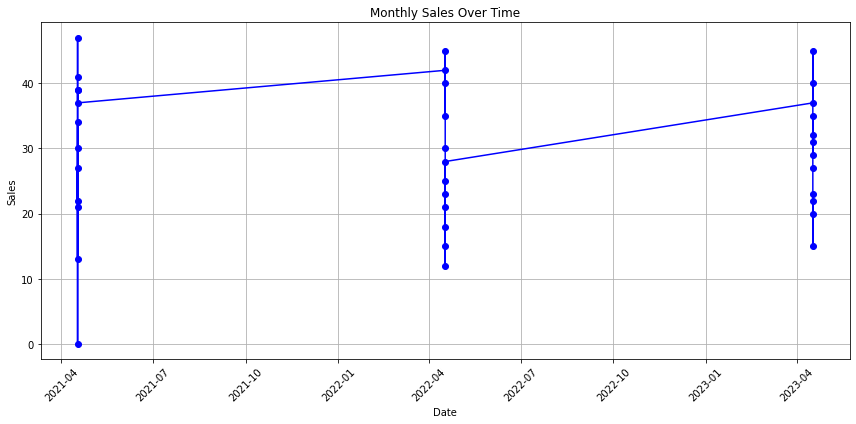

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(sales_data_pd['LastSaleDate'], sales_data_pd['Sales'], marker='o', linestyle='-', color='b')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [0]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(sales_data_pd['Sales'])
adf_statistic = adf_result[0]
p_value = adf_result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

if p_value < 0.05:
    print("The time series is stationary (reject null hypothesis).")
else:
    print("The time series is not stationary (fail to reject null hypothesis).")

ADF Statistic: -5.279916448785878
p-value: 6.025286702855192e-06
The time series is stationary (reject null hypothesis).


In [0]:
from pmdarima import auto_arima
model = auto_arima(sales_data_pd['Sales'], 
                   seasonal=False, 
                   stepwise=True, 
                   trace=True, 
                   suppress_warnings=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=283.112, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=350.973, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=281.261, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=323.284, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=279.624, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=281.220, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=281.258, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=279.268, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=281.257, Time=0.20 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=311.615, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=272.630, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=272.891, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=270.800, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=276.925, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=272.5

In [0]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(sales_data_pd['Sales'], order=(1, 0, 0))
arima_result = arima_model.fit()
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -132.400
Date:                Sat, 05 Oct 2024   AIC                            270.800
Time:                        19:02:43   BIC                            275.550
Sample:                             0   HQIC                           272.458
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.9594      3.206      9.032      0.000      22.675      35.243
ar.L1          0.4508      0.193      2.336      0.020       0.072       0.829
sigma2        91.0445     19.396      4.694      0.0

In [0]:
# Forecast the next 12 periods
forecast = arima_result.forecast(steps=12)
print("Forecasted Sales for the next 12 months:")
print(forecast)

Forecasted Sales for the next 12 months:
36    25.822238
37    27.545225
38    28.321912
39    28.672027
40    28.829851
41    28.900995
42    28.933066
43    28.947522
44    28.954039
45    28.956977
46    28.958301
47    28.958898
Name: predicted_mean, dtype: float64


In [0]:
import pandas as pd
forecast_index = pd.date_range(start=sales_data_pd['LastSaleDate'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')
forecast_df = pd.DataFrame(forecast.values, index=forecast_index, columns=['Forecasted Sales'])

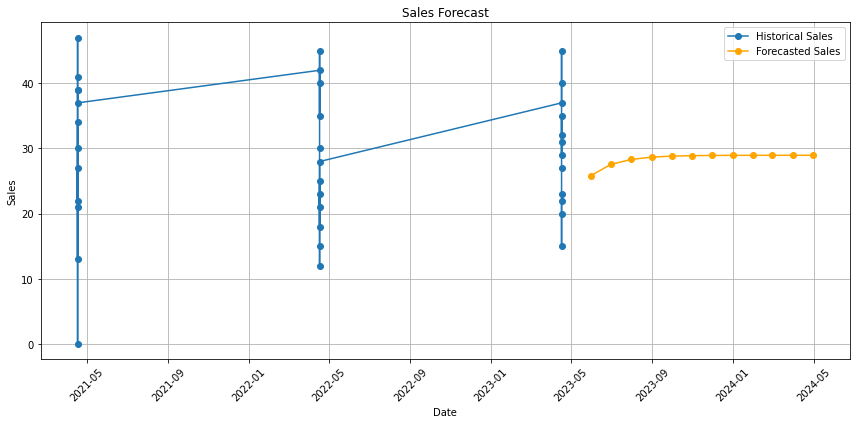

In [0]:
plt.figure(figsize=(12, 6))
plt.plot(sales_data_pd['LastSaleDate'], sales_data_pd['Sales'], label='Historical Sales', marker='o')
plt.plot(forecast_df.index, forecast_df['Forecasted Sales'], label='Forecasted Sales', marker='o', color='orange')
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
sales_data_pd['ARIMA_Predictions'] = arima_result.predict(start=0, end=len(sales_data_pd) - 1)
mae = mean_absolute_error(sales_data_pd['Sales'], sales_data_pd['ARIMA_Predictions'])
mape = np.mean(np.abs((sales_data_pd['Sales'] - sales_data_pd['ARIMA_Predictions']) / sales_data_pd['Sales'])) * 100
rmse = np.sqrt(mean_squared_error(sales_data_pd['Sales'], sales_data_pd['ARIMA_Predictions']))
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 7.51
Mean Absolute Percentage Error (MAPE): inf%
Root Mean Squared Error (RMSE): 9.57
